In [1]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import numpy as np
from matplotlib import pyplot as plt

fire_perimeters = "WFIGS_-_Current_Wildland_Fire_Perimeters.csv"
fire_locations = "WFIGS_-_Wildland_Fire_Locations_Full_History.csv"

In [2]:
fire_perimeters_df = pd.read_csv(fire_perimeters)
fire_locations_df = pd.read_csv(fire_locations)

C:\Users\wallh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (13,14,32,61,64,77,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
fire_locations_df.columns

Index(['X', 'Y', 'OBJECTID', 'ABCDMisc', 'ADSPermissionState',
       'CalculatedAcres', 'ContainmentDateTime', 'ControlDateTime',
       'DailyAcres', 'DiscoveryAcres', 'DispatchCenterID',
       'EstimatedCostToDate', 'FinalFireReportApprovedByTitle',
       'FinalFireReportApprovedByUnit', 'FinalFireReportApprovedDate',
       'FireBehaviorGeneral', 'FireBehaviorGeneral1', 'FireBehaviorGeneral2',
       'FireBehaviorGeneral3', 'FireCause', 'FireCauseGeneral',
       'FireCauseSpecific', 'FireCode', 'FireDepartmentID',
       'FireDiscoveryDateTime', 'FireMgmtComplexity', 'FireOutDateTime',
       'FireStrategyConfinePercent', 'FireStrategyFullSuppPercent',
       'FireStrategyMonitorPercent', 'FireStrategyPointZonePercent',
       'FSJobCode', 'FSOverrideCode', 'GACC', 'ICS209ReportDateTime',
       'ICS209ReportForTimePeriodFrom', 'ICS209ReportForTimePeriodTo',
       'ICS209ReportStatus', 'IncidentManagementOrganization', 'IncidentName',
       'IncidentShortDescription', 'Inciden

In [4]:
fire_discovered_and_out = fire_locations_df[["FireDiscoveryDateTime", "FireOutDateTime", "IncidentName", "X", "Y", "POOState", "FireCause"]].dropna()

# Use .loc to filter for the state of california
fire_discovered_and_out = fire_discovered_and_out.loc[fire_discovered_and_out["POOState"] == "US-CA"]

fire_discovery_date_time = []
fire_out_date_time = []
fire_out_delta = []

# We loop through all the rows, converting them to datetime objects
for i in range(len(fire_discovered_and_out)):
    
    # We try to convert the discovery time and fire out time to a datetime object, if that raises an exception then
    # we instead add a null value, (that we'll drop later)
    try:
        started = pd.to_datetime(fire_discovered_and_out["FireDiscoveryDateTime"].iloc[i], format="%Y/%m/%d %H:%M:%S+%f", utc=True)
        fire_discovery_date_time.append(started)
    except:
        started = datetime.strptime(fire_discovered_and_out["FireDiscoveryDateTime"].iloc[i], "%Y/%m/%d %H:%M:%S+%f", utc=True)
        fire_discovery_date_time.append(pd.nan)
        
    try:    
        out = pd.to_datetime(fire_discovered_and_out["FireOutDateTime"].iloc[i], format="%Y/%m/%d %H:%M:%S+%f", utc=True)
        fire_out_date_time.append(out)
    except:
        out = datetime.strptime(fire_discovered_and_out["FireOutDateTime"].iloc[i], "%Y/%m/%d %H:%M:%S+%f", utc=True)
        fire_out_date_time.append(np.nan)
    
    # We also make a new column to keep track of how long the fire lasted
    # A few rows must have been improperly filled out, as the fire was put out before it started
    # So we try and if the time delta is negative, or it otherwise doesn't work we put in NaN which we will drop later
    try:
        time_delta = pd.Timedelta(out-started)
    
        if time_delta.days < 0:
            fire_out_delta.append(np.nan)
        
        else:
            fire_out_delta.append(pd.Timedelta(time_delta))
    except:
        fire_out_delta.append(np.nan)

# now we update our dataframe 
fire_discovered_and_out["FireDiscoveryDateTime"] = fire_discovery_date_time
fire_discovered_and_out["FireOutDateTime"] = fire_out_date_time
fire_discovered_and_out["FireOutDelta"] = fire_out_delta
fire_discovered_and_out.head()


,FireDiscoveryDateTime,FireOutDateTime,IncidentName,X,Y,POOState,FireCause,FireOutDelta
9,2015-06-09 03:36:00+00:00,2015-06-09 16:57:00+00:00,41,-119.693013,37.638805,US-CA,Human,0 days 13:21:00
23,2020-08-15 18:31:58+00:00,2020-08-16 15:59:59+00:00,SOUTH FORK,-122.901014,41.202338,US-CA,Human,0 days 21:28:01
24,2016-09-02 22:49:00+00:00,2016-09-04 00:59:59+00:00,Crown,-119.446513,38.114475,US-CA,Human,1 days 02:10:59
65,2018-10-09 20:36:59+00:00,2018-10-09 23:00:00+00:00,CAHUILLA,-116.769612,33.528925,US-CA,Human,0 days 02:23:01
79,2019-10-15 15:21:59+00:00,2019-10-26 20:23:59+00:00,Brannon,-123.441114,41.376505,US-CA,Unknown,11 days 05:02:00


In [25]:
fire_discovered_and_out = fire_locations_df[["FireDiscoveryDateTime", "IncidentName", "X", "Y", "POOState", "FireCause"]].dropna()

# Use .loc to filter for the state of california
fire_discovered_and_out = fire_discovered_and_out.loc[fire_discovered_and_out["POOState"] == "US-CA"]

fire_discovery_local_time = []
fire_discovery_date_time = []
coordinates = []

start_time = "2012/01/01 00:00:00+00"
time_format="%Y/%m/%d %H:%M:%S+%f"
start_datetime = pd.to_datetime(start_time, format=time_format, utc=False).tz_localize(tz="US/Pacific")


# We loop through all the rows, converting them to datetime objects
for i in range(len(fire_discovered_and_out)):
        started = pd.to_datetime(fire_discovered_and_out["FireDiscoveryDateTime"].iloc[i], format=time_format, utc=True)
        
        fire_discovery_date_time.append(started)
        fire_discovery_local_time.append(started.tz_convert(tz="US/Pacific"))
        
        x = fire_discovered_and_out["X"].iloc[i]
        y = fire_discovered_and_out["Y"].iloc[i]
        coordinates.append([x,y])

# now we update our dataframe 


fire_discovered_and_out["FireDiscoveryDateTime"] = fire_discovery_date_time
fire_discovered_and_out["FireDiscoveryLocalTime"] = fire_discovery_local_time
fire_discovered_and_out["Coordinates"] = coordinates

fire_discovered_and_out = fire_discovered_and_out[["FireDiscoveryDateTime", "FireDiscoveryLocalTime","FireCause", "Coordinates"]].loc[fire_discovered_and_out["FireDiscoveryLocalTime"] >= start_datetime]
print(fire_discovered_and_out["FireDiscoveryDateTime"].min())
print(len(fire_discovered_and_out))

fire_discovered_and_out.head()

2014-04-09 22:34:59+00:00
46112


,FireDiscoveryDateTime,FireDiscoveryLocalTime,FireCause,Coordinates
1,2020-02-28 20:45:40+00:00,2020-02-28 12:45:40-08:00,Unknown,"[-118.180712157, 33.8089848330001]"
9,2015-06-09 03:36:00+00:00,2015-06-08 20:36:00-07:00,Human,"[-119.693012774, 37.638805129]"
22,2017-10-09 14:50:17+00:00,2017-10-09 07:50:17-07:00,Undetermined,"[-118.678021302, 34.2014857180001]"
23,2020-08-15 18:31:58+00:00,2020-08-15 11:31:58-07:00,Human,"[-122.901013744, 41.2023381670001]"
24,2016-09-02 22:49:00+00:00,2016-09-02 15:49:00-07:00,Human,"[-119.446512788, 38.1144751910001]"


In [26]:
fire_discovered_and_out

,FireDiscoveryDateTime,FireDiscoveryLocalTime,FireCause,Coordinates
1,2020-02-28 20:45:40+00:00,2020-02-28 12:45:40-08:00,Unknown,"[-118.180712157, 33.8089848330001]"
9,2015-06-09 03:36:00+00:00,2015-06-08 20:36:00-07:00,Human,"[-119.693012774, 37.638805129]"
22,2017-10-09 14:50:17+00:00,2017-10-09 07:50:17-07:00,Undetermined,"[-118.678021302, 34.2014857180001]"
23,2020-08-15 18:31:58+00:00,2020-08-15 11:31:58-07:00,Human,"[-122.901013744, 41.2023381670001]"
24,2016-09-02 22:49:00+00:00,2016-09-02 15:49:00-07:00,Human,"[-119.446512788, 38.1144751910001]"
...,...,...,...,...
228559,2022-07-15 20:22:59+00:00,2022-07-15 13:22:59-07:00,Undetermined,"[-116.683793813, 32.642133776]"
228566,2022-07-15 20:44:46+00:00,2022-07-15 13:44:46-07:00,Undetermined,"[-118.75623228, 34.143434837]"
228567,2022-07-15 20:48:35+00:00,2022-07-15 13:48:35-07:00,Undetermined,"[-118.106732219, 34.7041149350001]"
228570,2022-07-15 21:04:51+00:00,2022-07-15 14:04:51-07:00,Undetermined,"[-120.63065896, 37.9459750890001]"


In [27]:
print(fire_discovered_and_out["FireDiscoveryLocalTime"].min())
(len(fire_discovered_and_out))
print(start_datetime)

2014-04-09 15:34:59-07:00
2012-01-01 00:00:00-08:00


In [28]:
# Now we dropna from this finished dataframe
fire_time_delta_cleaned = fire_discovered_and_out.dropna()

In [29]:
# Here we define a bunch of functions to return a list of fire counts broken down by month, hour and by day of a given month
# There's a much easier way to do this with groupby, but whatever

def fire_counts_by_month(data):
    fire_counts = [0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(data)):
        month = data["FireDiscoveryLocalTime"].iloc[i].tz_convert(tz="US/Pacific").month
        fire_counts[month -1] += 1
    return fire_counts

def fire_counts_by_hour(data):
    
    fire_counts = []
    for i in range(24):
        fire_counts.append(0)
    
    for i in range(len(data)):
        hour = data["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").hour
        fire_counts[hour] += 1
    return fire_counts

# This one, in addition to the dataset, takes the target month as an integer and the number of days in that month
def fire_counts_by_day(data, target_month, days):
    fire_counts = []
    for i in range(days):
        fire_counts.append(0)

    for i in range(len(data)):
        month = data["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").month
        if month == target_month:
            day = fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").day
            fire_counts[day -1] += 1
    return fire_counts

[1657, 1885, 1825, 2719, 4603, 6529, 8868, 5941, 4199, 3633, 2402, 1851]


<BarContainer object of 12 artists>

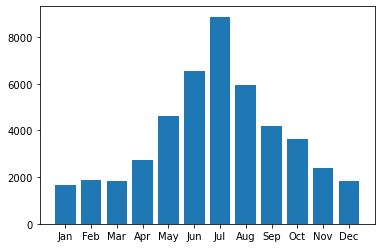

In [30]:
fire_counts = fire_counts_by_month(fire_time_delta_cleaned)
print(fire_counts)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.bar(months, fire_counts)

[926, 765, 677, 696, 697, 824, 1030, 1489, 1718, 1956, 2237, 2657, 3108, 3448, 3737, 3496, 3293, 2912, 2359, 2026, 1779, 1728, 1399, 1155]


<BarContainer object of 24 artists>

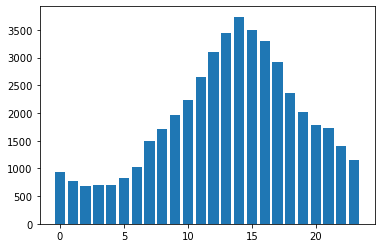

In [31]:
fire_counts = fire_counts_by_hour(fire_time_delta_cleaned)
print(fire_counts)
plt.bar(range(24), fire_counts)

<BarContainer object of 31 artists>

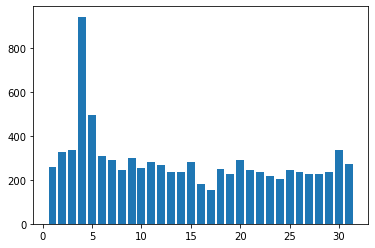

In [32]:
fire_counts = fire_counts_by_day(fire_time_delta_cleaned, 7, 31)

plt.bar(range(1, 32), fire_counts)

<BarContainer object of 31 artists>

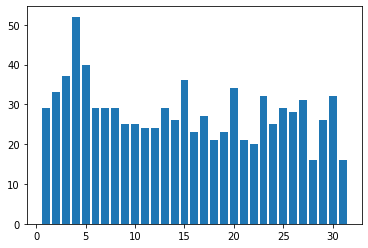

In [33]:
fire_counts = fire_counts_by_day(fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Human"], 7, 31)

plt.bar(range(1, 32), fire_counts)

In [34]:
# Here we set the fireDiscoveryDateTime as the index (makes it easier to get the month, day, hour, etc.)

fire_time_delta_cleaned.index = fire_time_delta_cleaned["FireDiscoveryDateTime"]
fire_time_delta_cleaned.index.month

Int64Index([ 2,  6, 10,  8,  9, 12,  9,  5,  5, 10,
            ...
             7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
           dtype='int64', name='FireDiscoveryDateTime', length=46112)

In [35]:
fire_time_delta_cleaned.groupby(fire_time_delta_cleaned.index.month).count()

,FireDiscoveryDateTime,FireDiscoveryLocalTime,FireCause,Coordinates
FireDiscoveryDateTime,,,,
1,1663,1663,1663,1663
2,1880,1880,1880,1880
3,1821,1821,1821,1821
4,2707,2707,2707,2707
5,4602,4602,4602,4602
6,6489,6489,6489,6489
7,8869,8869,8869,8869
8,5985,5985,5985,5985
9,4198,4198,4198,4198


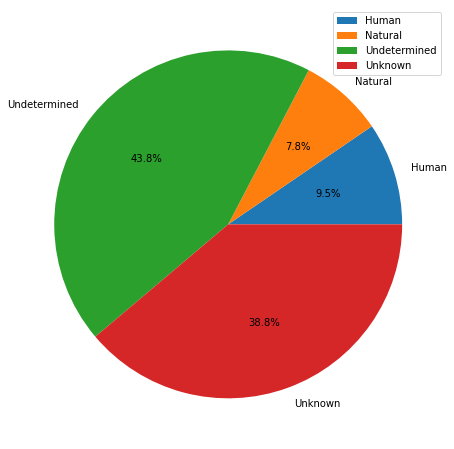

In [36]:
fire_time_delta_cleaned.groupby("FireCause").size().plot.pie(ylabel='', autopct='%1.1f%%', figsize = [8,8])
plt.legend(loc="best")

In [37]:
# Here we add hour and month columns to the dataframe to use for our groupby, localized to pacific time zone

time_of_day = []
for i in range(len(fire_time_delta_cleaned)):
    time_of_day.append(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").hour)

fire_time_delta_cleaned["LocalTimeOfDay"] = time_of_day

count_by_month = []
for i in range(len(fire_time_delta_cleaned)):
    count_by_month.append(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").month)

fire_time_delta_cleaned["LocalMonth"] = count_by_month

count_by_year = []
for i in range(len(fire_time_delta_cleaned)):
    count_by_year.append(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").year)

fire_time_delta_cleaned["LocalYear"] = count_by_year

In [38]:
local_time = []

for i in range(len(fire_time_delta_cleaned)):
    times = []
    times.append(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").hour)
    times.append(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").month)
    times.append(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").year)
    
    local_time.append(times)
fire_time_delta_cleaned["LocalTime"] = local_time

In [39]:
fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[0].tz_convert(tz="US/Pacific")

Timestamp('2020-02-28 12:45:40-0800', tz='US/Pacific')

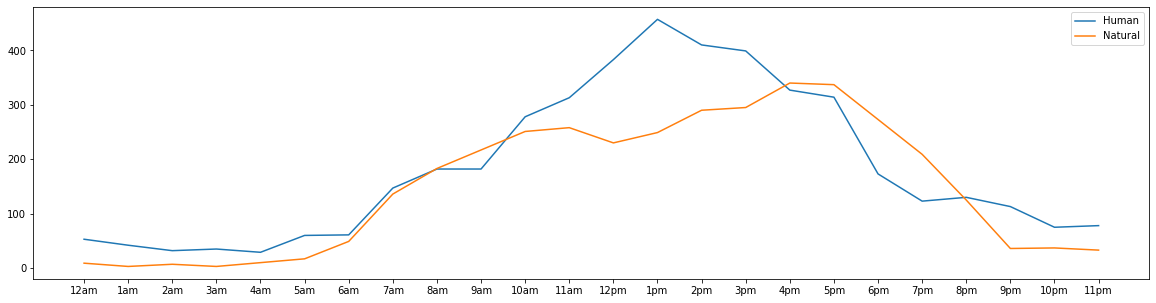

In [40]:
fire_by_time_human = fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Human"].groupby("LocalTimeOfDay").size()
fire_by_time_natural = fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Natural"].groupby("LocalTimeOfDay").size()
times_of_day = ["12am", "1am", "2am", "3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am", "12pm", "1pm", "2pm", "3pm", "4pm", "5pm", "6pm", "7pm", "8pm", "9pm", "10pm", "11pm"]

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(times_of_day, fire_by_time_human, label="Human")
ax.plot(times_of_day, fire_by_time_natural, label="Natural")
ax.legend()

plt.show()

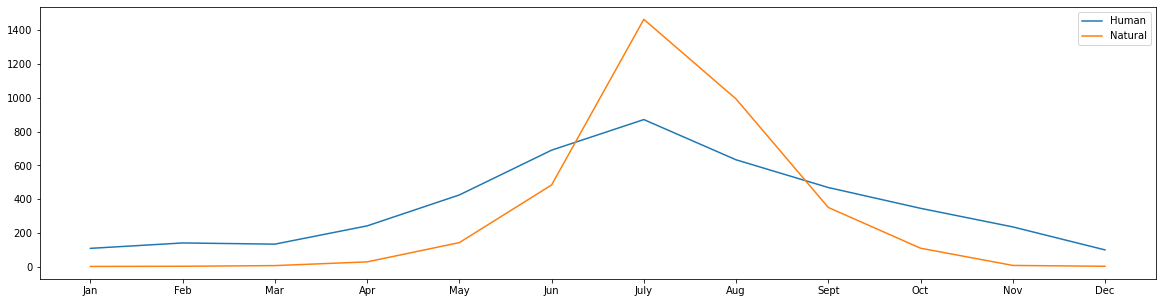

In [41]:
fire_by_month_human = fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Human"].groupby("LocalMonth").size()
fire_by_month_natural = fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Natural"].groupby("LocalMonth").size()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(months, fire_by_month_human, label="Human")
ax.plot(months, fire_by_month_natural, label="Natural")
ax.legend()

plt.show()

In [47]:
import requests

weather_api_key = "41485cb3418a4616ba791d2bc924bf61"
dt = int(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[0].value / 1000000000)
lat = fire_time_delta_cleaned["Coordinates"].iloc[0][1]
lon = fire_time_delta_cleaned["Coordinates"].iloc[0][0]

url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&units=imperial&appid={weather_api_key}"

# url = f"https://history.openweathermap.org/data/3.0/history/timemachine?lat={lat}&lon={lon}&dt={dt}&appid={weather_api_key}"
weather_report = requests.get(url).json()

In [20]:
weather_report

NameError: name 'weather_report' is not defined

In [42]:
fire_time_delta_cleaned["Coordinates"].iloc[0]

[-118.180712157, 33.8089848330001]

In [43]:
fire_time_delta_cleaned

,FireDiscoveryDateTime,FireDiscoveryLocalTime,FireCause,Coordinates,LocalTimeOfDay,LocalMonth,LocalYear,LocalTime
FireDiscoveryDateTime,,,,,,,,
2020-02-28 20:45:40+00:00,2020-02-28 20:45:40+00:00,2020-02-28 12:45:40-08:00,Unknown,"[-118.180712157, 33.8089848330001]",12,2,2020,"[12, 2, 2020]"
2015-06-09 03:36:00+00:00,2015-06-09 03:36:00+00:00,2015-06-08 20:36:00-07:00,Human,"[-119.693012774, 37.638805129]",20,6,2015,"[20, 6, 2015]"
2017-10-09 14:50:17+00:00,2017-10-09 14:50:17+00:00,2017-10-09 07:50:17-07:00,Undetermined,"[-118.678021302, 34.2014857180001]",7,10,2017,"[7, 10, 2017]"
2020-08-15 18:31:58+00:00,2020-08-15 18:31:58+00:00,2020-08-15 11:31:58-07:00,Human,"[-122.901013744, 41.2023381670001]",11,8,2020,"[11, 8, 2020]"
2016-09-02 22:49:00+00:00,2016-09-02 22:49:00+00:00,2016-09-02 15:49:00-07:00,Human,"[-119.446512788, 38.1144751910001]",15,9,2016,"[15, 9, 2016]"
...,...,...,...,...,...,...,...,...
2022-07-15 20:22:59+00:00,2022-07-15 20:22:59+00:00,2022-07-15 13:22:59-07:00,Undetermined,"[-116.683793813, 32.642133776]",13,7,2022,"[13, 7, 2022]"
2022-07-15 20:44:46+00:00,2022-07-15 20:44:46+00:00,2022-07-15 13:44:46-07:00,Undetermined,"[-118.75623228, 34.143434837]",13,7,2022,"[13, 7, 2022]"
2022-07-15 20:48:35+00:00,2022-07-15 20:48:35+00:00,2022-07-15 13:48:35-07:00,Undetermined,"[-118.106732219, 34.7041149350001]",13,7,2022,"[13, 7, 2022]"


In [44]:
len(fire_time_delta_cleaned)

46112

In [21]:
fire_time_delta_cleaned.drop(["FireDiscoveryLocalTime"], axis=1, inplace=True)


fire_time_delta_cleaned.reset_index(drop=True).to_json("wildfiresCleaned.json")
fire_time_delta_cleaned

,FireDiscoveryDateTime,IncidentName,Coordinates,FireCause,LocalTimeOfDay,LocalMonth
FireDiscoveryDateTime,,,,,,
2020-02-28 20:45:40+00:00,2020-02-28 20:45:40+00:00,LAC-066100,"[-118.180712157, 33.8089848330001]",Unknown,12,2
2015-06-09 03:36:00+00:00,2015-06-09 03:36:00+00:00,41,"[-119.693012774, 37.638805129]",Human,20,6
2017-10-09 14:50:17+00:00,2017-10-09 14:50:17+00:00,LAC-302109,"[-118.678021302, 34.2014857180001]",Undetermined,7,10
2020-08-15 18:31:58+00:00,2020-08-15 18:31:58+00:00,SOUTH FORK,"[-122.901013744, 41.2023381670001]",Human,11,8
2016-09-02 22:49:00+00:00,2016-09-02 22:49:00+00:00,Crown,"[-119.44651278799999, 38.114475191000096]",Human,15,9
...,...,...,...,...,...,...
2022-07-15 20:22:59+00:00,2022-07-15 20:22:59+00:00,BORDER 24,"[-116.683793813, 32.642133776]",Undetermined,13,7
2022-07-15 20:44:46+00:00,2022-07-15 20:44:46+00:00,FRED,"[-118.75623228, 34.143434837]",Undetermined,13,7
2022-07-15 20:48:35+00:00,2022-07-15 20:48:35+00:00,LAC-236357,"[-118.106732219, 34.7041149350001]",Undetermined,13,7


In [18]:
fire_time_delta_cleaned.drop(["FireDiscoveryDateTime", "FireDiscoveryLocalTime", ], axis=1, inplace=True)
fire_time_delta_cleaned.reset_index(drop=True).to_json("wildfiresCleaned2.json", orient="split", index=False)

In [22]:
fire_time_delta_cleaned.groupby("FireCause").count()

,FireDiscoveryDateTime,FireDiscoveryLocalTime,IncidentName,Coordinates,LocalTimeOfDay,LocalMonth,LocalYear
FireCause,,,,,,,
Human,4396,4396,4396,4396,4396,4396,4396
Natural,3597,3597,3597,3597,3597,3597,3597
Undetermined,20215,20215,20215,20215,20215,20215,20215
Unknown,17904,17904,17904,17904,17904,17904,17904


In [17]:
fire_time_delta_cleaned

,FireDiscoveryDateTime,FireDiscoveryLocalTime,FireCause,LocalTime
FireDiscoveryDateTime,,,,
2020-02-28 20:45:40+00:00,2020-02-28 20:45:40+00:00,2020-02-28 12:45:40-08:00,Unknown,"[12, 2, 2020]"
2015-06-09 03:36:00+00:00,2015-06-09 03:36:00+00:00,2015-06-08 20:36:00-07:00,Human,"[20, 6, 2015]"
2017-10-09 14:50:17+00:00,2017-10-09 14:50:17+00:00,2017-10-09 07:50:17-07:00,Undetermined,"[7, 10, 2017]"
2020-08-15 18:31:58+00:00,2020-08-15 18:31:58+00:00,2020-08-15 11:31:58-07:00,Human,"[11, 8, 2020]"
2016-09-02 22:49:00+00:00,2016-09-02 22:49:00+00:00,2016-09-02 15:49:00-07:00,Human,"[15, 9, 2016]"
...,...,...,...,...
2022-07-15 20:22:59+00:00,2022-07-15 20:22:59+00:00,2022-07-15 13:22:59-07:00,Undetermined,"[13, 7, 2022]"
2022-07-15 20:44:46+00:00,2022-07-15 20:44:46+00:00,2022-07-15 13:44:46-07:00,Undetermined,"[13, 7, 2022]"
2022-07-15 20:48:35+00:00,2022-07-15 20:48:35+00:00,2022-07-15 13:48:35-07:00,Undetermined,"[13, 7, 2022]"
